# Práctica 2

## Problema 1
Suponga el mecanismo de movimiento de barras de control de un reactor, donde la BC se posiciona por medio de un sistema piñon-cremallera accionado por un motor  de corriente continua (MCC).

$$
\begin{align*}
L\frac{di(t)}{dt}+Ri(t)&=V(t)-e(t)\\
e(t)&=K_e\dot{\theta}(t)\\
T_m(t)&=K_ti(t)\\
T_m(t)&=J_{eq}\ddot{\theta}(t)+b\dot{\theta}(t)\\
x_{BC}(t)&=K_{BC}\theta(t)
\end{align*}
$$

```{figure} mcc_bctrl.png
:alt: Diagrama motor
:width: 50%
:align: center

Diagrama motor de comando de barra de control
```

donde $L=0.5$ Hy, $R=1\Omega$, $J_{eq}=0.01$ kg.m $^2$ /s $^2$, $K_e=0.01$ V.seg/rad $K_t=0.01$ Nm/A $(K=K_e=K_t)$. $\theta$ es el ángulo girado por el eje y $V$ es la tensión de la fuente.

1. Considere $V$ la entrada del sistema, $X_{BC}$ (desplazamiento vertical de la barra) la salida y condiciones iniciales nulas. Calcule la función transferencia del sistema.
1. Suponga que la barra se debe mover a una velocidad máxima de 2cm/s y que la máxima tensión de la fuente no supera los 24V, ¿Cuánto vale $K_{BC}$? (Aplicar teorema del valor final)
1. Grafique la posición de la barra y la velocidad de la barra para una entrada escalón. Ayuda: Recordar la propiedad de que la transformada de Laplace de que la derivada de una función es $s$ multiplicada por la transformada de Laplace de la misma función, es decir:

- **Derivada**: $\mathcal{L}\left\{\dfrac{df(t)}{dt}\right\}=sF(s), \text{considerando } f(0)=0$

In [11]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

Definiendo Variables

In [8]:
L= 0.5
R= 1
Jeq=0.01
Ke=0.01
Kt=0.01
b=0.1

En función de las variables temporales se calculan sus transformadas considerando condiciones iniciales nulas

$$
\begin{align*}
L\frac{di(t)}{dt}+Ri(t)&=V(t)-e(t)\\
e(t)&=K_e\dot{\theta}(t)\\
T_m(t)&=K_ti(t)\\
T_m(t)&=J_{eq}\ddot{\theta}(t)+b\dot{\theta}(t)\\
x_{BC}(t)&=K_{BC}\theta(t)
\end{align*}
$$

$$
\begin{align*}
LsI(s)+RI(s)&=V(s)-E(s)\\
E(s)&=K_es\theta(s)\\
T_m(s)&=K_tI(s)\\
T_m(s)&=J_{eq}s^2\theta(s)+bs\theta(s)\\
X_{BC}(s)&=K_{BC}\theta(s)\\
\end{align*}
$$

Luego, del sistema de ecuaciones la función de transferencia del sistema es...

$$
\begin{align*}
\frac{X_{BC}(s)}{V(s)}&=\frac{K_{BC}K_{t}}{J_{eq}Ls^3+(Lb+RJ_{eq})s^2+(Rb+K_eK_t)s}
\end{align*}
$$

Sea la máxima velocidad a t muy grande y la máxima tensión soportada...

$$
\begin{align*}
\dot{X}_{BC}(t)&= 0,02m/s;\\ t&\rightarrow \infty; \\
V(s)&=24\frac{1}{s}
\end{align*}
$$

Por el Teorema de Valor final...

$$
\begin{align*}
\lim_{t \rightarrow \infty}f(t)&= \lim_{s \rightarrow 0}sF(s); \\
\lim_{t \rightarrow \infty}\dot{X}_{BC}(t)&=0,02 m/s= \lim_{s \rightarrow 0}s^2X(s)\\
0,02 m/s&= \lim_{s \rightarrow 0}\frac{24K_{BC}K_t}{Rb+K_eK_{BC}}\\
K_{BC}&=8,34.10^{-3} \frac{Nm}{A}\\
\end{align*}
$$

Luego,

In [55]:
Kbc=8.34E-3

In [56]:
s=ctrl.tf('s')

In [57]:
G=(Kbc*Kt)/(Jeq*L*(s**3)+(L*b+R*Jeq)*s**2+(R*b+Ke*Kt)*s);
G

TransferFunction(array([8.34e-05]), array([0.005 , 0.06  , 0.1001, 0.    ]))

In [58]:
t,x=ctrl.step_response(G)

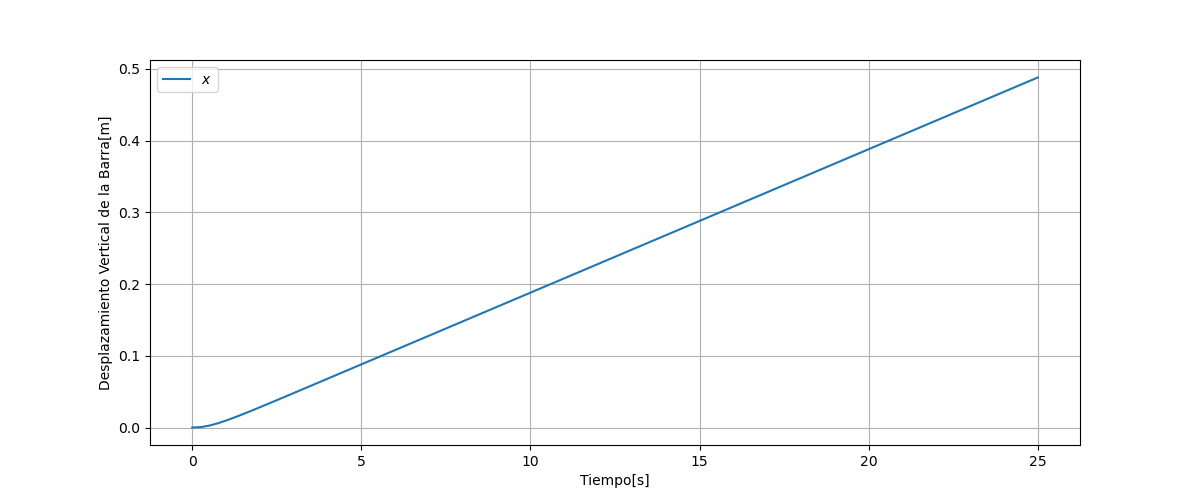

In [60]:
fig, ax=plt.subplots(figsize=(12,5))
ax.plot(t[:], 24*x[:], label=r'$x$')
ax.set_xlabel('Tiempo[s]')
ax.set_ylabel('Desplazamiento Vertical de la Barra[m]')
ax.legend()
ax.grid()

In [50]:
H=(Kbc*Kt)/(Jeq*L*(s**2)+(L*b+R*Jeq)*s+(R*b+Ke*Kt));
H

TransferFunction(array([8.34e-05]), array([0.005 , 0.06  , 0.1001]))

In [51]:
t,dx=ctrl.step_response(H)

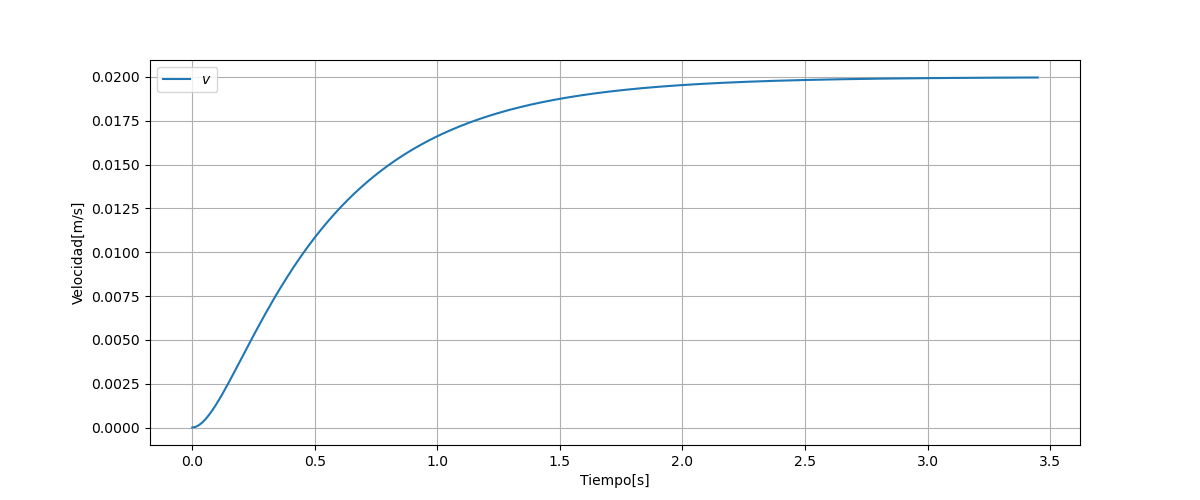

In [53]:
fig, ax=plt.subplots(figsize=(12,5))
ax.plot(t[:], 24*dx[:], label=r'$v$')
ax.set_xlabel('Tiempo[s]')
ax.set_ylabel('Velocidad[m/s]')
ax.legend()
ax.grid()

## Problema 2

Retomaremos en este problema el modelo del laboratorio de temperatura. El objetivo será obtener una función transferencia aproximada de $\dfrac{T_1(s)}{Q_1(s)}$.

Utilizaremos nuevamente el modelo del práctico anterior:

In [69]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [70]:
def derivs_tclab(t, x, u, params):
    "Las ecuaciones de las derivadads en las ecuaciones de estados"
    Q1 = u[0]
    Q2 = u[1]
    Ta=params.get('Ta', 19)
    P1max=params.get('P1max', 100)
    P2max=params.get('P2max', 200)
    H1 = x[0]
    H2 = x[1]
    T1 = x[2]
    T2 = x[3]
    DeltaTaH1 = Ta - H1
    DeltaTaH2 = Ta - H2
    DeltaT12 = H1 - H2
    dH1 = P1max * Q1 / 5720 + DeltaTaH1 / 20 - DeltaT12 / 100
    dH2 = P2max * Q2 / 5720 + DeltaTaH2 / 20 + DeltaT12 / 100
    dT1 =(H1 - T1)/140
    dT2 = (H2 - T2)/140
    return [dH1, dH2, dT1, dT2]


def output_tclab(t, x, u, params):
    "Las ecuaciones de las salida"
    return x[2], x[3]

tclab_sys = ctrl.NonlinearIOSystem(updfcn=derivs_tclab, 
                                  outfcn=output_tclab, 
                                  inputs=('Q1', 'Q2'), 
                                  outputs=('T1', 'T2'), 
                                  states=['H1', 'H2', 'T1', 'T2'], 
                                  name='tclab')

Ahora entonces deberemos aplicar un escalón de 10% de potencia en $Q_1$. Esto lo haremos definiendo nuevamente $U_1$ que 

$$
\begin{align*}
U_1(t) = 10\%\qquad &\text{para } t>200\\
U_1(t) = 0\%\qquad  &\text{para } 0<t\leq 10\\
U_2(t) = 0\%\qquad  &\text{para todo } t
\end{align*}
$$

esto se realiza mediante la siguiente función:

In [71]:
T=np.linspace(0,2000, 2001)
def Usignal(T):
    U = np.zeros((2, len(T)))
    for i, t in enumerate(T):
        U[0,i] = 10 if t > 200 else  0
        U[1,i] = 0        
    return U

U=Usignal(T)

Grafico $U_1$ y $U_2$ para ver si es lo que queremos.

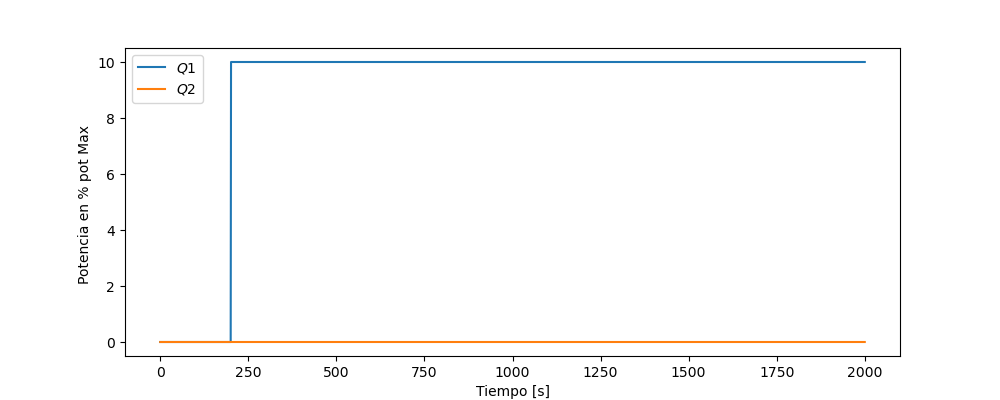

In [72]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(T, U[0,:], label=r'$Q1$')
ax.plot(T, U[1,:], label=r'$Q2$')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Potencia en % pot Max ')
ax.legend();

De esta figura vemos que $Q1$ y $Q2$ valen lo que queríamos. Por lo tanto estamos listos realizar la simulación.

In [73]:
X0 = [19,19, 19, 19]
t,y = ctrl.input_output_response(tclab_sys, T, U, X0)

## Se pide:

1. Graficar la salida $T_1$ obtenida de la simulación anterior.
1. A partir de esta gráfica obtener los parámetros de una función transferencia de primer orden.
1. Implementar la función transferencia solicitada, graficarla y compararla contra la respuesta original. Observar y comparar con atención valores de inicio y fin de $T_1$.

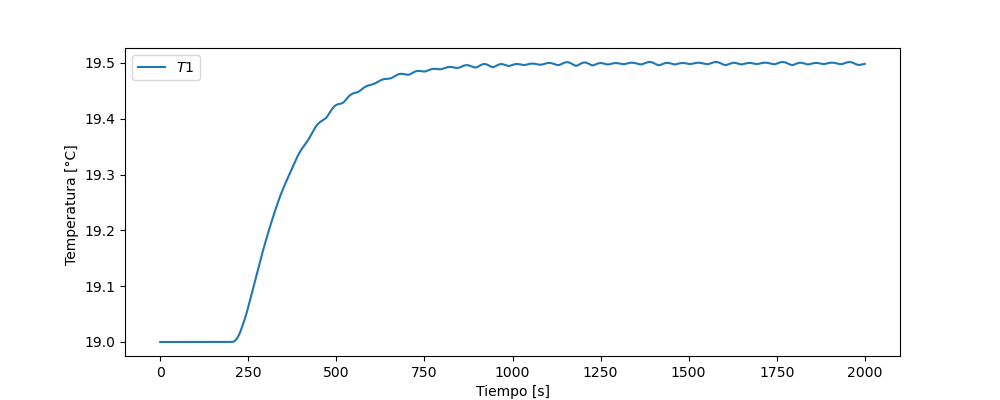

In [76]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(T, y[1,:], label=r'$T1$')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Temperatura [°C] ')
ax.legend();

Del gráfico puede observarse que se trata de un sistema de primer orden con una demora. Una acumulación.

$$
\begin{align*}
F(s) = k\frac{1}{T_2s+1}
\end{align*}
$$

A la demora se la puede aproximar con la aproximacion de Pade

$$
\begin{align*}
e^{-Ls} = \frac{1-0.5Ls}{1+0.5Ls}
\end{align*}
$$

Graficamente $T_2$ sale a un valor de 0,63k